# Modeling Complex Time Series

#### Loading Libraries

In [25]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnigs
import warnings

# 
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Statistical Models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot

# Effective Iteration Progress
from tqdm import tqdm_notebook
# Effective Interators
from itertools import product
# Annotation Type Support
from typing import Union

In [5]:
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline

#### Simulating an ARMA(p,q) Process

In [11]:
np.random.seed(42)

# Setting Coefficients
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

#Appying ARMA
ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [12]:
# Checking for Stationarity
ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042645
p-value: 1.7078466680101036e-08


##### Checking on ACF

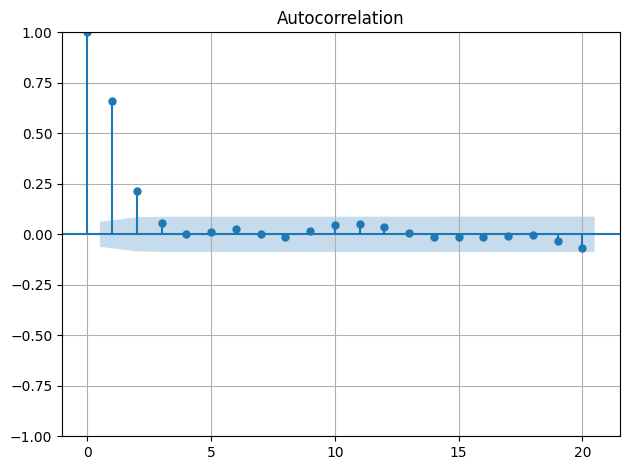

In [15]:
plot_acf(ARMA_1_1, lags=20);

plt.tight_layout()
plt.grid(True)

##### Checking on PACF

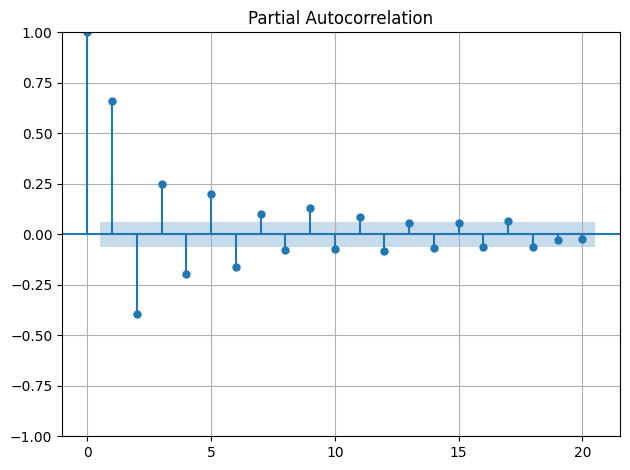

In [16]:
plot_pacf(ARMA_1_1, lags=20);

plt.tight_layout()
plt.grid(True)

#### Selecting a Model Using The AIC

In [19]:
# Possible values
ps = range(0, 4, 1)
qs = range(0, 4, 1)

In [20]:
# Unique combination list
order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


##### Unique Models ARMA(p,q) Function

In [23]:
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [24]:
# Applying it
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2805.930279
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


##### Qualitative Analysis: Studying the Q-Q Plot

Text(0.5, 1.0, 'Normally Distributed')

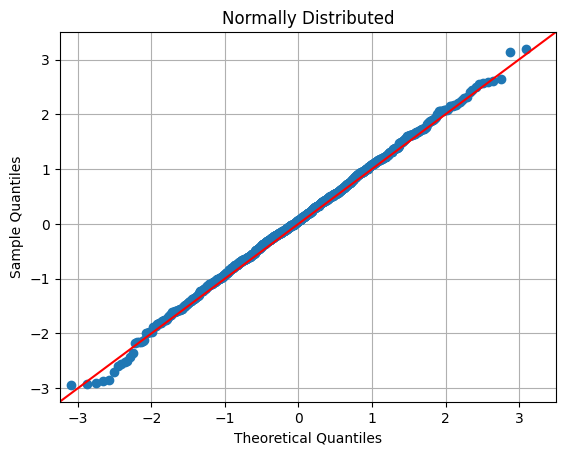

In [27]:
# Normally Distributed
normal = np.random.normal(size=1000)

qqplot(normal, line='45');

plt.grid(True)
plt.title('Normally Distributed')

Text(0.5, 1.0, 'Not Normally Distributed')

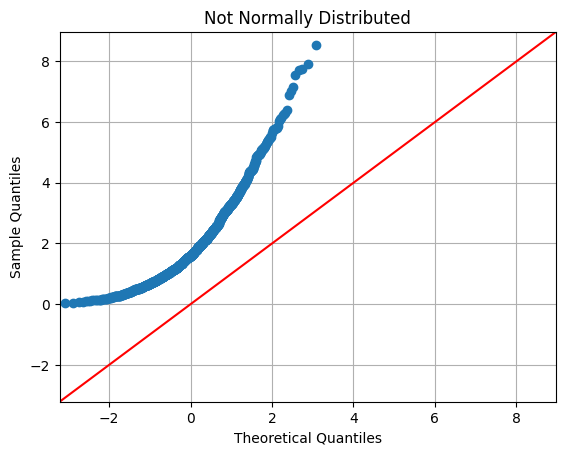

In [28]:
gamma = np.random.default_rng().standard_gamma(shape=2, size=1000)

qqplot(gamma, line='45');

plt.grid(True)
plt.title('Not Normally Distributed')

##### NOTE: Quantitative Analysis is performed based on: Applying Ljung-Box Test

#### Performing Residual Analysis